# [Dataset](https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification)

# **Genre Prediction**


# Frame The Problem And Look At The Big Picture

1. ***Define the objective in business terms***:

- The goal of this project is to build a system that can classify music genres based on audio features extracted from songs. For this, we’re using the GTZAN dataset, which contains tracks labeled across 10 genres, such as Blues, Jazz, Rock, and Classical. The project involves analyzing the dataset to uncover patterns in the audio features that can help distinguish one genre from another. This work has practical applications in many areas. For example, music streaming platforms could use a system like this to improve their recommendation algorithms by better understanding the genres of songs. It could also help organize large music libraries by automatically tagging tracks with the correct genre, saving time and reducing human errors. Beyond that, it could provide insights into genre trends, which could be useful for the music industry in understanding listener preferences and market dynamics. Our ultimate goal is to develop a system that is both accurate and insightful, demonstrating the potential of audio-based classification for real-world use cases. Along the way, we’ll focus on understanding how audio features correlate with genre characteristics and how to improve the system’s accuracy through experimentation and optimization.

2. ***How will your solution be used***:
- Music streaming platforms could integrate it into their recommendation systems
- Music libraries could use it for automated genre tagging
- Music industry analysts could use it to study genre trends and market dynamics
- Could be used in real-time (for live genre classification) or batch processing (for library organization)

3. ***Current solutions/workarounds***:
- Manual genre tagging by music experts
- Existing audio classification like https://www.submithub.com/whats-my-genre

4. ***Problem framing***:
- This is a supervised learning problem as we have labeled data (songs with known genres)
- It's a multi-class classification task (10 different genres)
- Can be implemented as either online (real-time) or offline (batch) depending on the use case
- The GTZAN dataset provides labeled training data

5. ***Performance measurement***:
- Classification metrics like accuracy, precision, recall, and F1-score
- Confusion matrix to understand misclassifications between genres
- Below shows we're using `recall_macro` as the scoring metric for GridSearchCV
- `recall_macro` is a scoring metric used to evaluate the performance of a multi-class classification model. It calculates the recall for each class separately and then computes the unweighted (arithmetic) average of those recall values across all classes.
- Cross-validation scores to ensure robust performance

6. ***Minimum performance needed***:
- Highest accuracy possible, As many songs should be assigned their correct label as possible.
- Prioritizing: Recall

7. ***Comparable problems***:
- Speech recognition
- Sound classification
- Audio fingerprinting
- Music mood classification
- Artist identification from audio  
These all use similar audio feature extraction and classification techniques

8. ***Human expertise availability***:
- Music experts can manually classify genres
- Domain knowledge about audio features and their relationship to genres is available (as shown in the feature descriptions)

9. ***Manual solution process***:  
A human would:
- Listen to the audio
- Identify key characteristics like:
  - Instruments used
  - Rhythm patterns
  - Tempo
  - Vocal style
  - Harmonic structure
- Compare these characteristics against known genre conventions
- Make a classification based on overall similarity to genre patterns

10. ***Assumptions made***:
- The 10 genres in GTZAN dataset are sufficient to represent music diversity
- 30-second segments are enough to determine genre
- The dataset is representative of real-world music
- The genre labels in the training data are accurate

These assumptions could be verified by:
- Validating genre labels with multiple music experts
- Testing the model on more recent music releases

# **Get The Data**

#### Imports:

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

#### Loading the data:

In [2]:
# Function to load the dataset
def load_dataset(dataset_name=None):
    return pd.read_csv(f'data/{dataset_name}')

In [3]:
sec_data = load_dataset('features_30_sec.csv')
data = load_dataset('features_3_sec.csv')

### Found Jazz #54 is corrupted

In [4]:
import os
import pandas as pd
import librosa
import numpy as np
import soundfile as sf

def extract_features(y, sr):
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr).mean()
    chroma_stft_var = librosa.feature.chroma_stft(y=y, sr=sr).var()
    rms = librosa.feature.rms(y=y).mean()
    rms_var = librosa.feature.rms(y=y).var()
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr).mean()
    spectral_centroid_var = librosa.feature.spectral_centroid(y=y, sr=sr).var()
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr).mean()
    spectral_bandwidth_var = librosa.feature.spectral_bandwidth(y=y, sr=sr).var()
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr).mean()
    rolloff_var = librosa.feature.spectral_rolloff(y=y, sr=sr).var()
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y=y).mean()
    zero_crossing_rate_var = librosa.feature.zero_crossing_rate(y=y).var()
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    mfcc_means = mfcc.mean(axis=1)
    mfcc_vars = mfcc.var(axis=1)
    return [
        chroma_stft, chroma_stft_var, rms, rms_var,
        spectral_centroid, spectral_centroid_var,
        spectral_bandwidth, spectral_bandwidth_var,
        rolloff, rolloff_var, zero_crossing_rate, zero_crossing_rate_var,
        *mfcc_means, *mfcc_vars
    ]

def split_and_process(file, output_dir, label, segment_duration=3):
    y, sr = librosa.load(file, sr=None)
    samples_per_segment = int(segment_duration * sr)
    for i, start_sample in enumerate(range(0, len(y), samples_per_segment)):
        end_sample = start_sample + samples_per_segment
        segment = y[start_sample:end_sample]
        
        if len(segment) < samples_per_segment:
            break
        
        output_filename = f"{os.path.splitext(os.path.basename(file))[0]}.{i}.wav"
        output_path = os.path.join(output_dir, output_filename)
        sf.write(output_path, segment, sr)

for file_name in data['filename']:
    input_file = f"./audio/{file_name.split('.')[0]}/{file_name}"
    output_directory = f"./audio/3_second/{file_name.split('.')[0]}"
    os.makedirs(output_directory, exist_ok=True)
    label = file_name.split('.')[0]
    try:
        split_and_process(input_file, output_directory, label)
    except Exception as e:
        print(f"Exception processing {input_file}: {e}")
    # print(f"Processed {input_file}")

C:\Users\franc\AppData\Local\Temp\ipykernel_23984\1599972703.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file, sr=None)
C:\Users\franc\AppData\Roaming\Python\Python312\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Exception processing ./audio/blues/blues.00000.0.wav: [Errno 2] No such file or directory: './audio/blues/blues.00000.0.wav'
Exception processing ./audio/blues/blues.00000.1.wav: [Errno 2] No such file or directory: './audio/blues/blues.00000.1.wav'
Exception processing ./audio/blues/blues.00000.2.wav: [Errno 2] No such file or directory: './audio/blues/blues.00000.2.wav'
Exception processing ./audio/blues/blues.00000.3.wav: [Errno 2] No such file or directory: './audio/blues/blues.00000.3.wav'
Exception processing ./audio/blues/blues.00000.4.wav: [Errno 2] No such file or directory: './audio/blues/blues.00000.4.wav'
Exception processing ./audio/blues/blues.00000.5.wav: [Errno 2] No such file or directory: './audio/blues/blues.00000.5.wav'
Exception processing ./audio/blues/blues.00000.6.wav: [Errno 2] No such file or directory: './audio/blues/blues.00000.6.wav'
Exception processing ./audio/blues/blues.00000.7.wav: [Errno 2] No such file or directory: './audio/blues/blues.00000.7.wav'


In [5]:
print(data.columns)


Index(['filename', 'length', 'chroma_stft_mean', 'chroma_stft_var', 'rms_mean',
       'rms_var', 'spectral_centroid_mean', 'spectral_centroid_var',
       'spectral_bandwidth_mean', 'spectral_bandwidth_var', 'rolloff_mean',
       'rolloff_var', 'zero_crossing_rate_mean', 'zero_crossing_rate_var',
       'harmony_mean', 'harmony_var', 'perceptr_mean', 'perceptr_var', 'tempo',
       'mfcc1_mean', 'mfcc1_var', 'mfcc2_mean', 'mfcc2_var', 'mfcc3_mean',
       'mfcc3_var', 'mfcc4_mean', 'mfcc4_var', 'mfcc5_mean', 'mfcc5_var',
       'mfcc6_mean', 'mfcc6_var', 'mfcc7_mean', 'mfcc7_var', 'mfcc8_mean',
       'mfcc8_var', 'mfcc9_mean', 'mfcc9_var', 'mfcc10_mean', 'mfcc10_var',
       'mfcc11_mean', 'mfcc11_var', 'mfcc12_mean', 'mfcc12_var', 'mfcc13_mean',
       'mfcc13_var', 'mfcc14_mean', 'mfcc14_var', 'mfcc15_mean', 'mfcc15_var',
       'mfcc16_mean', 'mfcc16_var', 'mfcc17_mean', 'mfcc17_var', 'mfcc18_mean',
       'mfcc18_var', 'mfcc19_mean', 'mfcc19_var', 'mfcc20_mean', 'mfcc20_var',
  

In [6]:
"""
import soundfile as sf
# Creating audio files for the 5 second increments

for i in range(0, len(data)):
    if i == 0:
        start = 0
    else:
        start = data.iloc[i-1]['end']
    end = data.iloc[i]['end']
    audio, sr = sf.read(f'data/UrbanSound8K/audio/fold{data.iloc[i]["fold"]}/{data.iloc[i]["slice_file_name"]}')
    sf.write(f'data/5_sec_audio/{data.iloc[i]["slice_file_name"]}', audio[int(start*sr):int(end*sr)], sr)

"""

'\nimport soundfile as sf\n# Creating audio files for the 5 second increments\n\nfor i in range(0, len(data)):\n    if i == 0:\n        start = 0\n    else:\n        start = data.iloc[i-1][\'end\']\n    end = data.iloc[i][\'end\']\n    audio, sr = sf.read(f\'data/UrbanSound8K/audio/fold{data.iloc[i]["fold"]}/{data.iloc[i]["slice_file_name"]}\')\n    sf.write(f\'data/5_sec_audio/{data.iloc[i]["slice_file_name"]}\', audio[int(start*sr):int(end*sr)], sr)\n\n'

In [7]:
sec_data.head()

filename  length  chroma_stft_mean  chroma_stft_var  rms_mean  \
0  blues.00000.wav  661794          0.350088         0.088757  0.130228   
1  blues.00001.wav  661794          0.340914         0.094980  0.095948   
2  blues.00002.wav  661794          0.363637         0.085275  0.175570   
3  blues.00003.wav  661794          0.404785         0.093999  0.141093   
4  blues.00004.wav  661794          0.308526         0.087841  0.091529   

    rms_var  spectral_centroid_mean  spectral_centroid_var  \
0  0.002827             1784.165850          129774.064525   
1  0.002373             1530.176679          375850.073649   
2  0.002746             1552.811865          156467.643368   
3  0.006346             1070.106615          184355.942417   
4  0.002303             1835.004266          343399.939274   

   spectral_bandwidth_mean  spectral_bandwidth_var  ...  mfcc16_var  \
0              2002.449060            85882.761315  ...   52.420910   
1              2039.036516           213843.755497  ...   55.356403   
2              1747.702312            76254.192257  ...   40.598766   
3              1596.412872           166441.494769  ...   44.427753   
4              1748.172116            88445.209036  ...   86.099236   

   mfcc17_mean  mfcc17_var  mfcc18_mean  mfcc18_var  mfcc19_mean  mfcc19_var  \
0    -1.690215   36.524071    -0.408979   41.597103    -2.303523   55.062923   
1    -0.731125   60.314529     0.295073   48.120598    -0.283518   51.106190   
2    -7.729093   47.639427    -1.816407   52.382141    -3.439720   46.639660   
3    -3.319597   50.206673     0.636965   37.319130    -0.619121   37.259739   
4    -5.454034   75.269707    -0.916874   53.613918    -4.404827   62.910812   

   mfcc20_mean  mfcc20_var  label  
0     1.221291   46.936035  blues  
1     0.531217   45.786282  blues  
2    -2.231258   30.573025  blues  
3    -3.407448   31.949339  blues  
4   -11.703234   55.195160  blues  

[5 rows x 60 columns]


#### *Data Overview*

- The dataset contains 2 sets of audio features including spectral measurements, MFCCs, and temporal characteristics with no missing values.
- One dataset containing 30 second samples and the corresponding values and the other 3 second samples, both have the same features
- The dataset contains 1000 30 second songs with 100 songs for each of the 10 genres in a `.wav` format.
- The dataset also contains a Mel Spectrogram corresponding to each of the songs.

| Feature | Description |
|---------|------------|
| chroma_stft | Represents pitch content by mapping spectral data into 12 pitch classes |
| rms | Root Mean Square energy - represents the loudness/volume of the audio |
| spectral_centroid | Indicates where the "center of mass" of the sound is - relates to sound brightness |
| spectral_bandwidth | Width of the spectrum - indicates the range of frequencies |
| rolloff | Frequency below which most of the signal's energy is contained |
| zero_crossing_rate | Rate at which the signal changes from positive to negative - relates to noisiness |
| harmony | Measure of harmonic content vs noise in the signal |
| perceptr | Perceptual features of the sound |
| tempo | Speed/pace of the music in beats per minute |
| mfcc1-20 | Mel-frequency cepstral coefficients - represent the overall shape of the spectral envelope |

Note: Each feature has both _mean and _var (variance) measurements, representing the average value and how much it varies throughout the audio sample.


- 1,000 entries with 60 columns
- All data fields are completely populated
- Data types:
  - float64: 57 columns (audio features)
  - int64: 1 column (length)
  - object: 2 columns (filename, label)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9990 entries, 0 to 9989
Data columns (total 60 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   filename                 9990 non-null   object 
 1   length                   9990 non-null   int64  
 2   chroma_stft_mean         9990 non-null   float64
 3   chroma_stft_var          9990 non-null   float64
 4   rms_mean                 9990 non-null   float64
 5   rms_var                  9990 non-null   float64
 6   spectral_centroid_mean   9990 non-null   float64
 7   spectral_centroid_var    9990 non-null   float64
 8   spectral_bandwidth_mean  9990 non-null   float64
 9   spectral_bandwidth_var   9990 non-null   float64
 10  rolloff_mean             9990 non-null   float64
 11  rolloff_var              9990 non-null   float64
 12  zero_crossing_rate_mean  9990 non-null   float64
 13  zero_crossing_rate_var   9990 non-null   float64
 14  harmony_mean            

In [9]:
data.describe()

length  chroma_stft_mean  chroma_stft_var     rms_mean       rms_var  \
count   9990.0       9990.000000      9990.000000  9990.000000  9.990000e+03   
mean   66149.0          0.379534         0.084876     0.130859  2.676388e-03   
std        0.0          0.090466         0.009637     0.068545  3.585628e-03   
min    66149.0          0.107108         0.015345     0.000953  4.379535e-08   
25%    66149.0          0.315698         0.079833     0.083782  6.145900e-04   
50%    66149.0          0.384741         0.085108     0.121253  1.491318e-03   
75%    66149.0          0.442443         0.091092     0.176328  3.130862e-03   
max    66149.0          0.749481         0.120964     0.442567  3.261522e-02   

       spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
count             9990.000000           9.990000e+03              9990.000000   
mean              2199.219431           4.166727e+05              2241.385959   
std                751.860611           4.349644e+05               543.854449   
min                472.741636           8.118813e+02               499.162910   
25%               1630.680158           1.231961e+05              1887.455790   
50%               2208.628236           2.650692e+05              2230.575595   
75%               2712.581884           5.624152e+05              2588.340505   
max               5432.534406           4.794119e+06              3708.147554   

       spectral_bandwidth_var  rolloff_mean  ...  mfcc16_mean   mfcc16_var  \
count            9.990000e+03   9990.000000  ...  9990.000000  9990.000000   
mean             1.182711e+05   4566.076592  ...     1.448240    49.988755   
std              1.013505e+05   1642.065335  ...     5.735149    34.442816   
min              1.183520e+03    658.336276  ...   -26.850016     1.325786   
25%              4.876553e+04   3378.311110  ...    -2.227478    29.584894   
50%              8.996072e+04   4631.377892  ...     1.461623    41.702393   
75%              1.585674e+05   5591.634521  ...     5.149752    59.274619   
max              1.235143e+06   9487.446477  ...    39.144405   683.932556   

       mfcc17_mean   mfcc17_var  mfcc18_mean   mfcc18_var  mfcc19_mean  \
count  9990.000000  9990.000000  9990.000000  9990.000000  9990.000000   
mean     -4.198706    51.962753     0.739943    52.488851    -2.497306   
std       5.677379    36.400669     5.181313    38.177120     5.111799   
min     -27.809795     1.624544   -20.733809     3.437439   -27.448456   
25%      -7.951722    29.863448    -2.516638    29.636197    -5.734123   
50%      -4.443021    42.393583     0.733772    41.831377    -2.702366   
75%      -0.726945    61.676964     3.888734    62.033906     0.514246   
max      34.048843   529.363342    36.970322   629.729797    31.365425   

        mfcc19_var  mfcc20_mean   mfcc20_var  
count  9990.000000  9990.000000  9990.000000  
mean     54.973829    -0.917584    57.322614  
std      41.585677     5.253243    46.444212  
min       3.065302   -35.640659     0.282131  
25%      30.496412    -4.004475    30.011365  
50%      43.435253    -1.030939    44.332155  
75%      65.328602     2.216603    68.210421  
max    1143.230591    34.212101   910.473206  

[8 rows x 58 columns]

### *Data Histograms*

- Looking at these histograms, most of the audio features (like pitch, volume, and frequency measurements) follow bell-shaped distributions centered around specific values, while the variance features (showing how much these measurements change) tend to have right-skewed distributions with long tails, meaning most songs have small variations but some have very large changes in their audio characteristics.

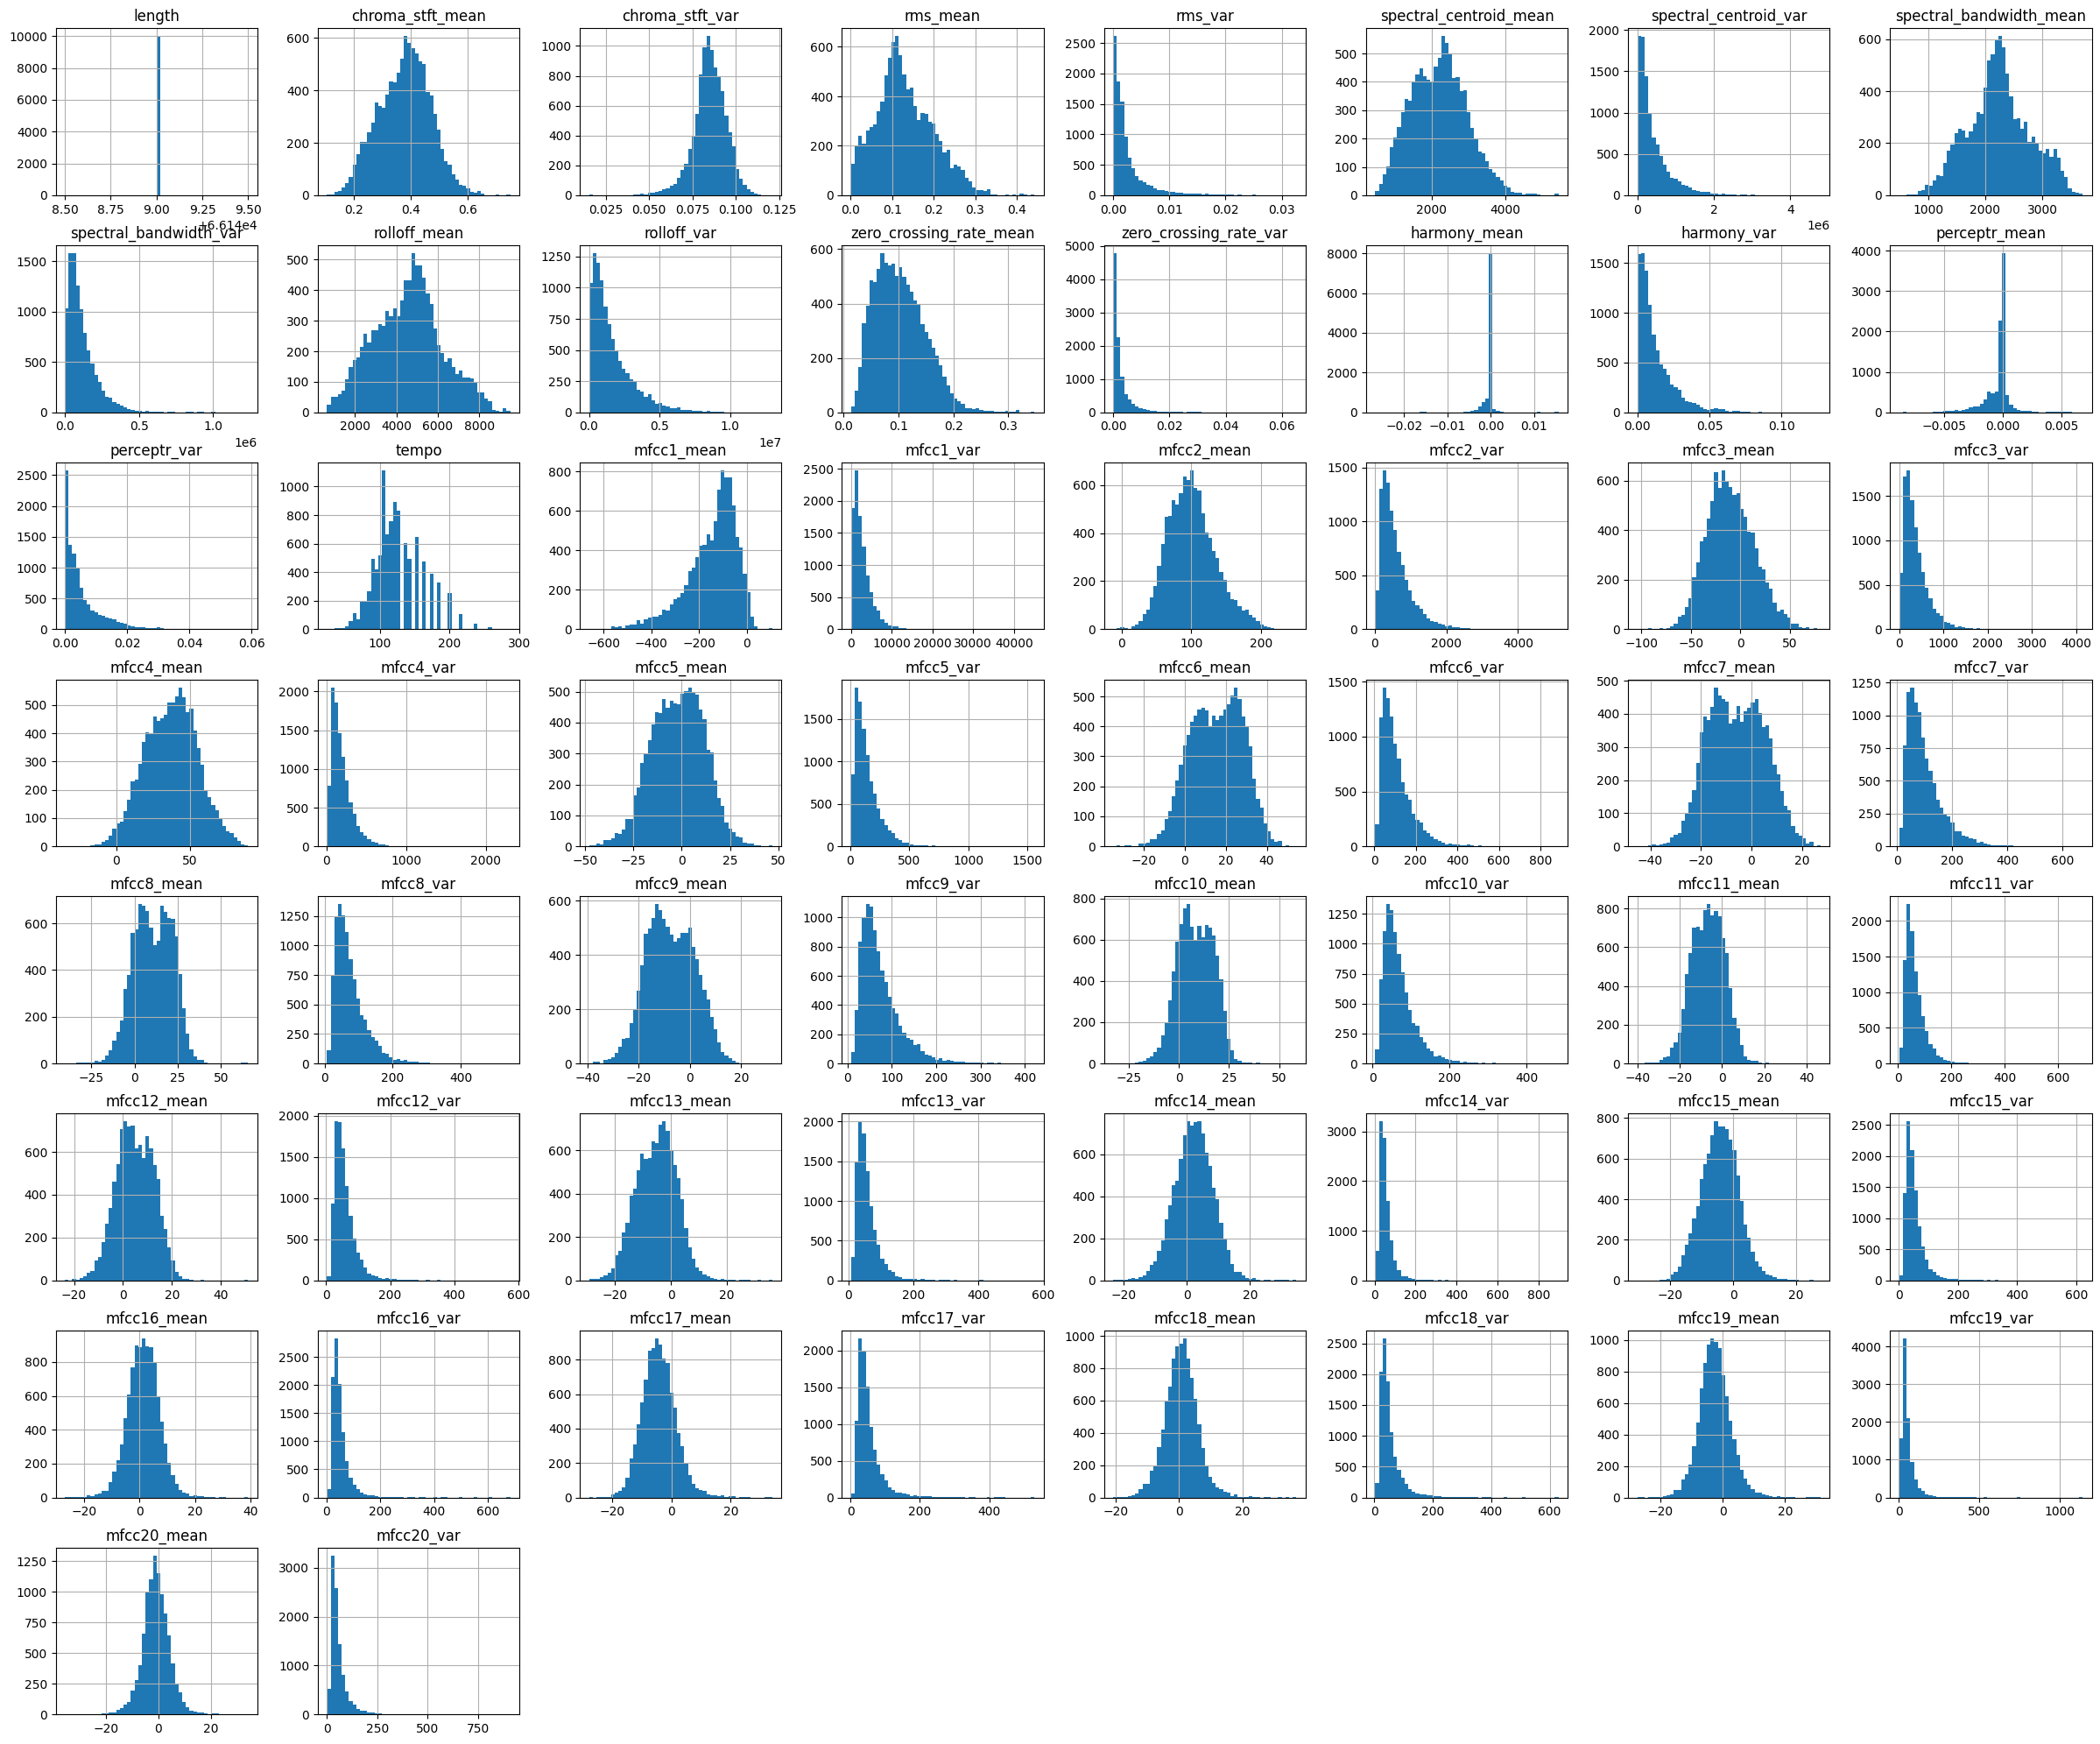

In [10]:
data.hist(bins=50, figsize=(30,25));

### *Splitting The Data Into Two Subsets*

-  The `train_set` containing 80% of the data for training and `test_set` containing 20% for testing, with the split being reproducible due to the specified `random_state`.

In [11]:
# Split the data into train and test sets
train, test = train_test_split(data, test_size=0.2, random_state=42, stratify=data['label'])
data = train

# **Discover & Visualize the Data to Gain Insights**

### *Correlation Matrix Of Numerical Features* 
- This correlation matrix might look a bit tricky, but you can spot some patterns between audio features and MFCCs. In the upper left section, you’ll notice some moderate relationships between spectral and temporal audio features.

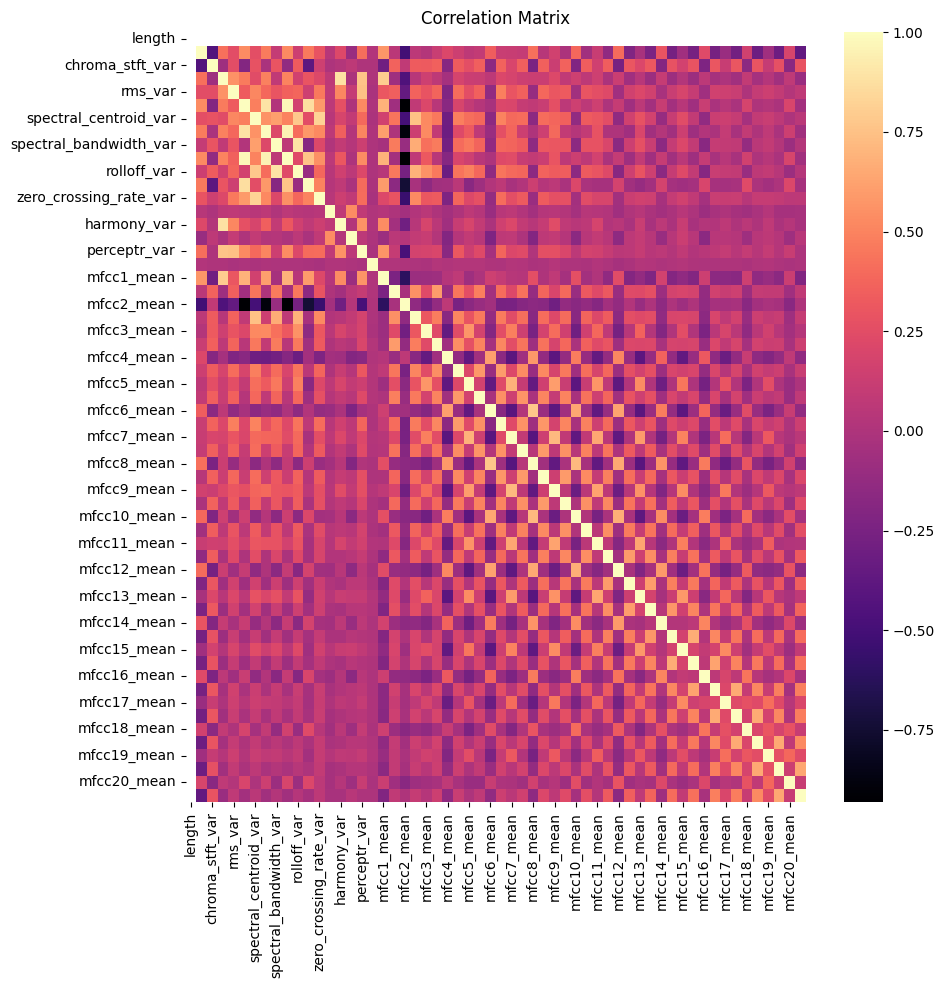

In [12]:
numeric_columns = data.select_dtypes(include=[np.number])

# Corelation matrix with sns
corr = numeric_columns.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=False, cmap='magma')
plt.title('Correlation Matrix')
plt.show()

### **RMS Feature Distributions Across Music Genres**

- The plot shows the distribution of the Root Mean Square (RMS) feature for different music genres, visualized using Kernel Density Estimation (KDE). It highlights how each genre's energy profile (loudness) varies, with genres like hip-hop and rock having distinct RMS characteristics compared to classical or jazz, which show more concentrated and narrower distributions.

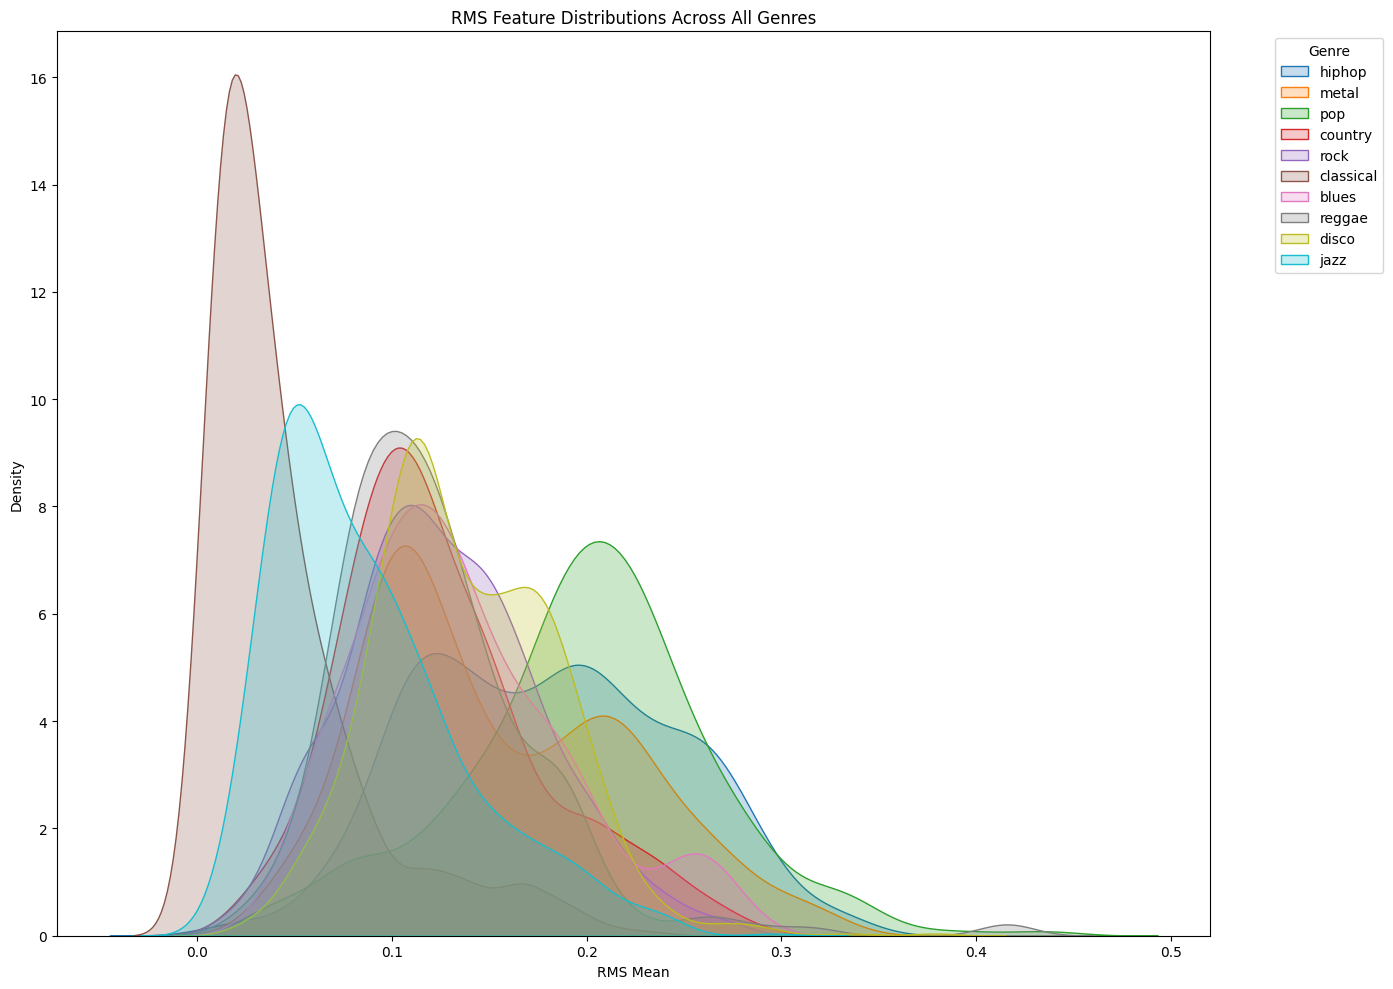

In [13]:
import warnings
plt.figure(figsize=(14, 10))

# Loop through all unique genres and plot their RMS feature distribution
warnings.filterwarnings('ignore')
for genre in data['label'].unique():
    sns.kdeplot(data=data[data['label'] == genre]['rms_mean'], label=genre, shade=True)

plt.title('RMS Feature Distributions Across All Genres')
plt.xlabel('RMS Mean')
plt.ylabel('Density')
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show();

### *Spectral Centroid Across Genres*
- This chart compares the brightness or treble characteristics of different music genres using box plots, where higher values indicate brighter, more treble-heavy sounds, and lower values indicate darker, more bass-heavy sounds. Pop music shows the highest median brightness while classical and blues genres tend toward darker tones, and jazz displays the most variability in its tonal characteristics, ranging from very dark to very bright sounds.

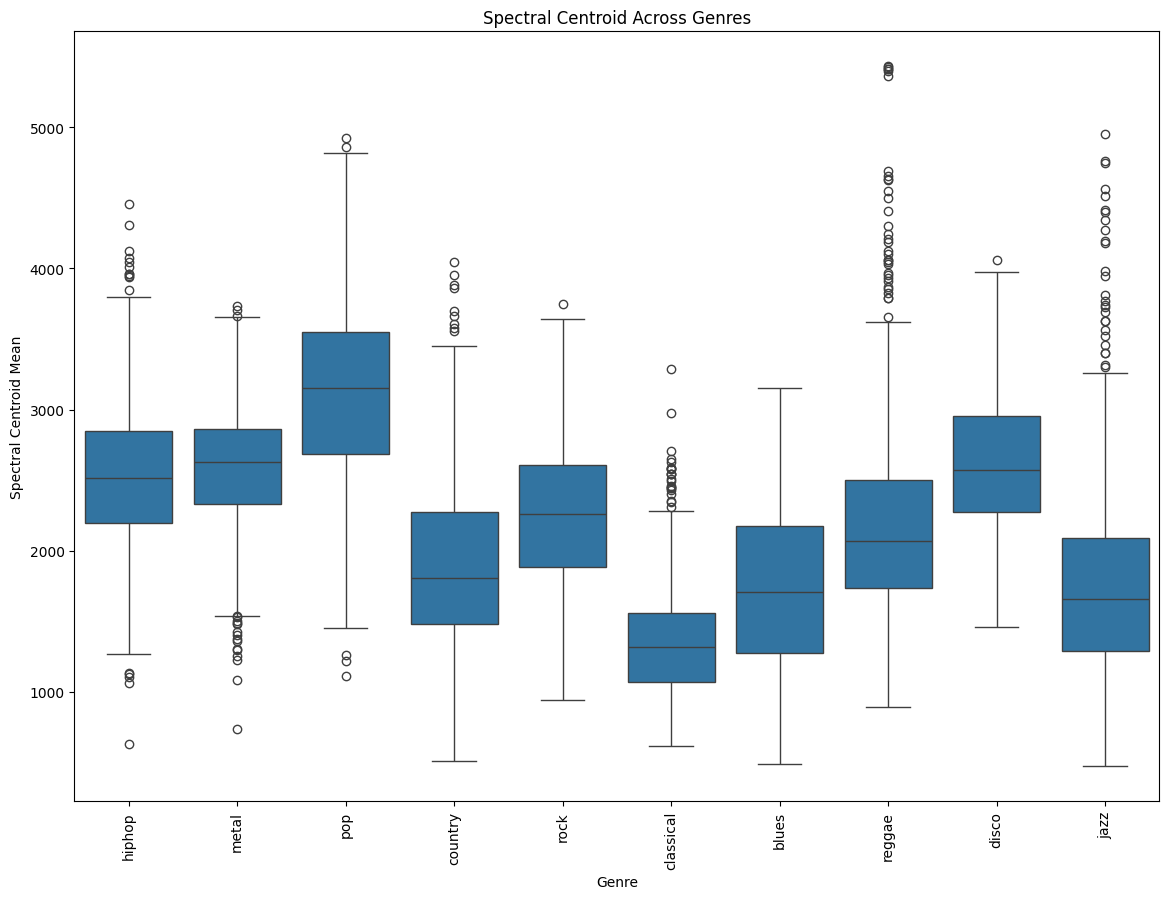

In [14]:
# Visualizing spectral_centroid across genres
plt.figure(figsize=(14, 10))
sns.boxplot(x='label', y='spectral_centroid_mean', data=data)
plt.title('Spectral Centroid Across Genres')
plt.xlabel('Genre')
plt.ylabel('Spectral Centroid Mean')
plt.xticks(rotation=90)
plt.show()



### *MFCC1 Mean Across Genres*

- This chart compares the first Mel-frequency cepstral coefficient (MFCC1) across different music genres, which reflects the overall energy distribution in the frequency spectrum. Classical music has the lowest median MFCC1 values and the most variability, indicating it has less consistent energy. Metal and pop, on the other hand, have higher median values, showing they have more consistent and energetic frequency content.

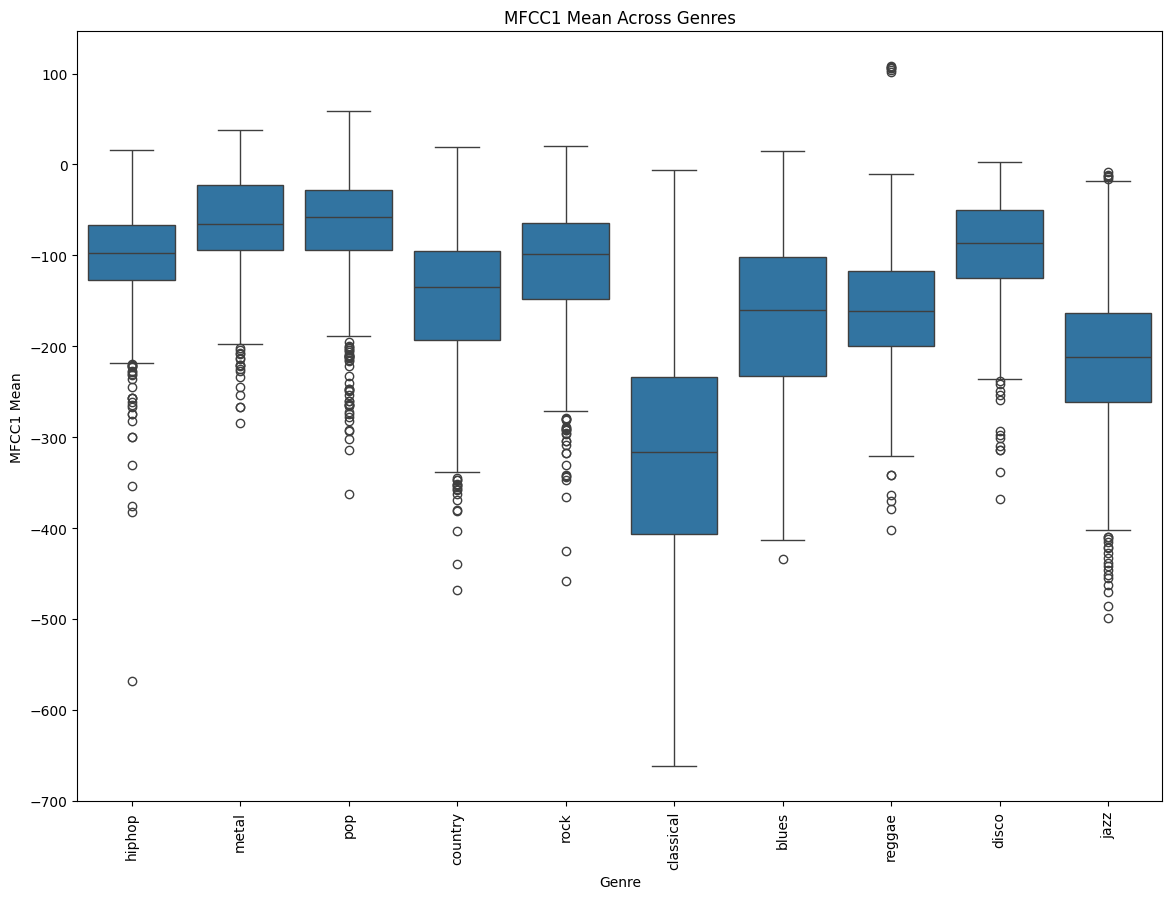

In [15]:
# Visualizing mfcc1_mean across genres
plt.figure(figsize=(14, 10))
sns.boxplot(x='label', y='mfcc1_mean', data=data)
plt.title('MFCC1 Mean Across Genres')
plt.xlabel('Genre')
plt.ylabel('MFCC1 Mean')
plt.xticks(rotation=90)
plt.show()

### *Using Librosa*

- **So we are going to use Librosa, which is a Python library for analyzing and processing audio signals, widely used in music information retrieval and machine learning applications.**

- This code uses **Librosa** to load an audio file, obtaining its time series (`y`) and sample rate (`sr`). It prints the shape of the audio array (`661504` samples), the sample rate (`22050 Hz`), and the audio length (`30 seconds`).










In [16]:
import librosa 
import librosa.display  
audio_path = "./audio/metal/metal.00094.wav"
# needs to be numpy 2.0 because librosa thinks its funny to break with numpy 1.21
%pip install numpy==2.0
# Load the audio file using librosa, y is the audio time series and sr is the sampling rate of y 
y, sr = librosa.load(audio_path)
y_shape = np.shape(y)  
print(f"y shape: {y_shape}, sample rate: {sr}, length: {y_shape[0] / sr} seconds")

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


y shape: (661504,), sample rate: 22050, length: 30.00018140589569 seconds


### Audio Waveform
- As you can see you can use librosa to create a visual representation of an audio waveform, or a audio signal as a waveplot, showing the changes in amplitude over time.



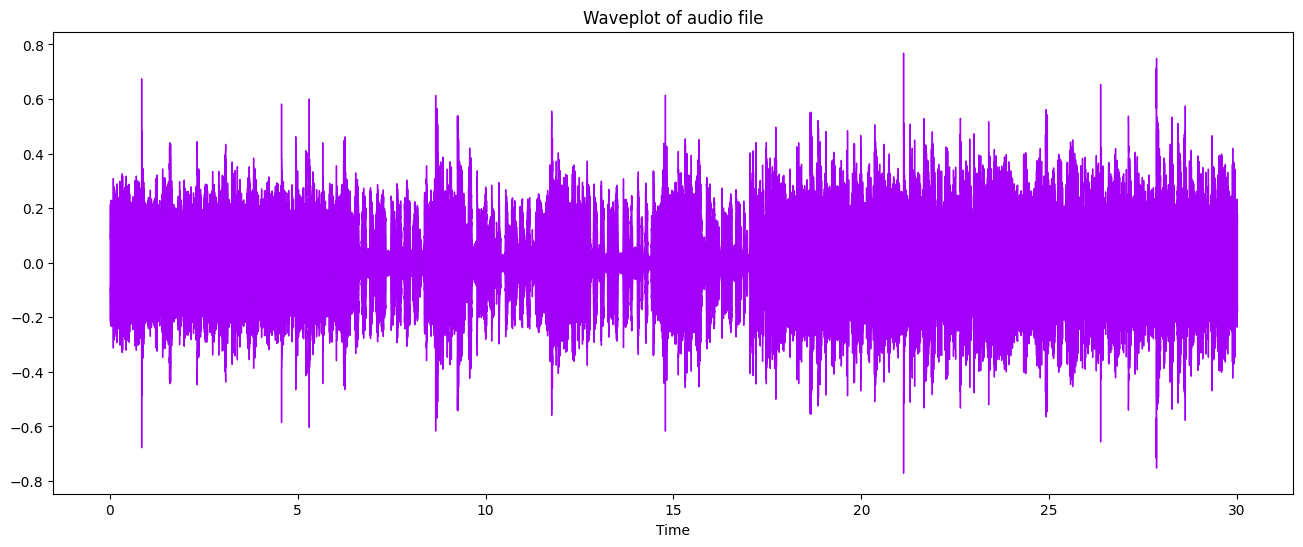

In [17]:
plt.figure(figsize=(16, 6)) 
librosa.display.waveshow(y, sr=sr, color="#A300F9") 
plt.title("Waveplot of audio file");

### *Audio STFT Spectogram*

- We can also use Librosa to create a spectrogram of an audio file, showing how its frequency content changes over time. It uses the Short-Time Fourier Transform (STFT) to convert the signal into a frequency domain and displays it in decibels on a logarithmic frequency scale.








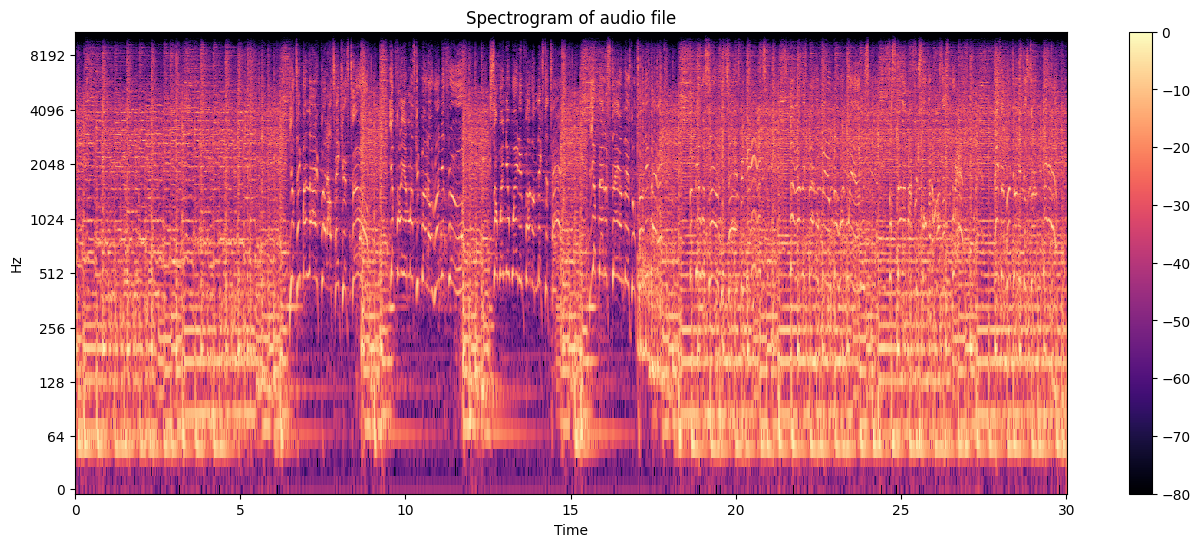

In [18]:
n_fft = 2048 
hop_length = 512  
audio_file, _ = librosa.effects.trim(y) 
D = np.abs(librosa.stft(audio_file, n_fft = n_fft, hop_length = hop_length))  
DB = librosa.amplitude_to_db(D, ref = np.max)  
plt.figure(figsize = (16, 6)) 
librosa.display.specshow(DB, sr = sr, hop_length = hop_length, x_axis = 'time', y_axis = 'log') 
plt.colorbar();
plt.title("Spectrogram of audio file");
plt.show()

### *Average Energy (RMS) by Genre*

- This bar graph shows the average RMS (Root Mean Square) energy for different music genres. The pop genre has the highest energy, while classical has the lowest. By the way the  RMS (Root Mean Square) energy is basicaly the loudness of an audio signal by calculating the square root of the average of the squared values of the signal's waveform

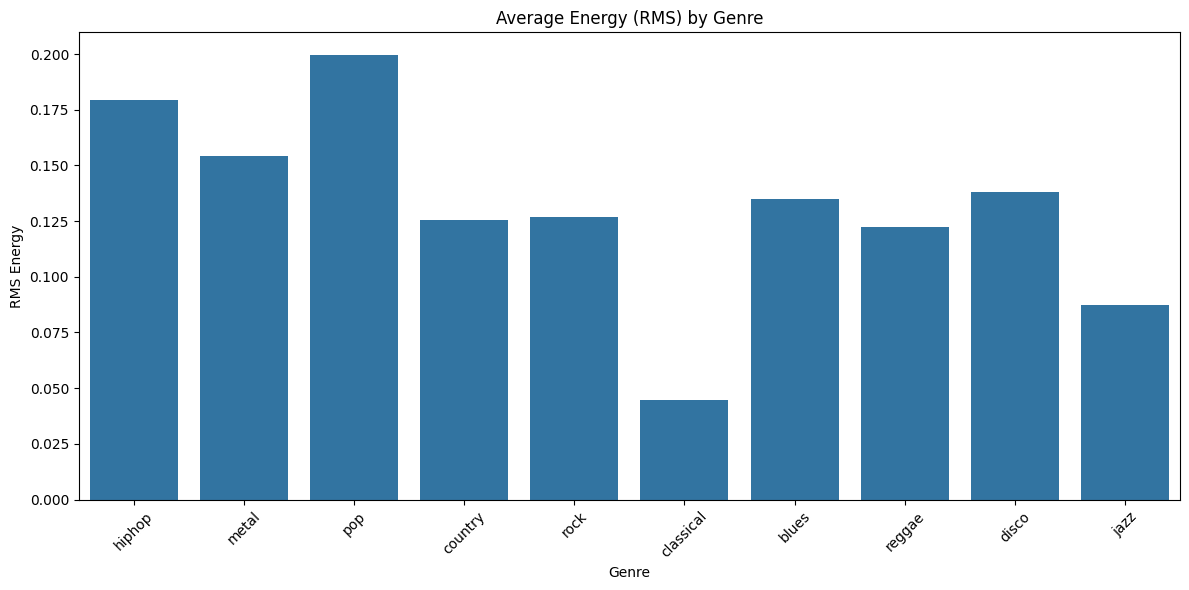

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.barplot(data=data, x='label', y='rms_mean', ci=None)
plt.title('Average Energy (RMS) by Genre')
plt.xlabel('Genre')
plt.ylabel('RMS Energy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Audio Mel Spectrogram

- This is similar to the other spectogram, its better for analyzing audio because it mimics how humans hear sound. It compresses the frequency axis to focus on the frequencies we are most sensitive to, making it more efficient for tasks like speech or music recognition (which is our case).

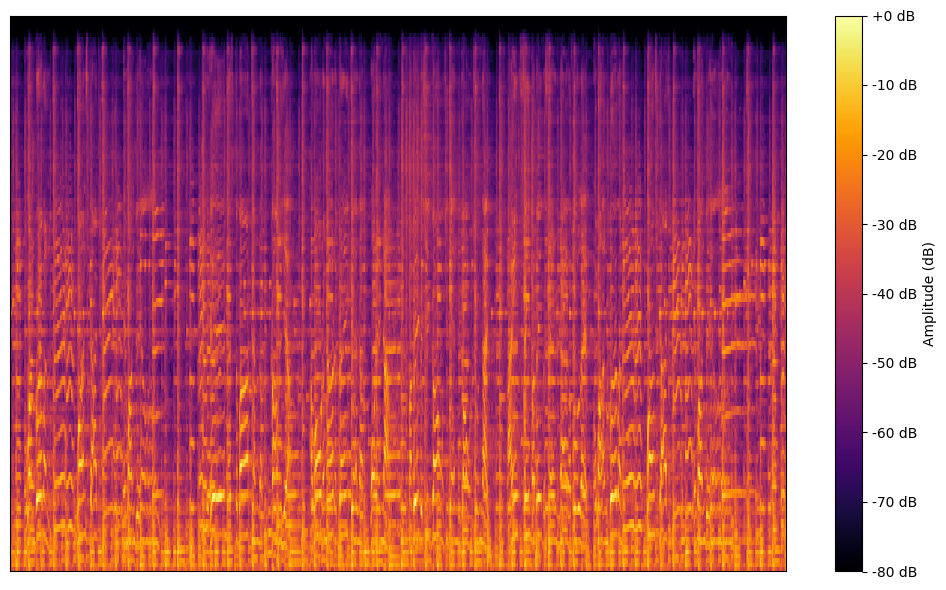

In [20]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

file = "./audio/blues/blues.00000.wav"  # Correct path
y, sr = librosa.load(file, sr=None)
mel_spec = librosa.feature.melspectrogram(y=y, sr=sr)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
plt.figure(figsize=(10, 6))
librosa.display.specshow(mel_spec_db, sr=sr, cmap='inferno')
plt.colorbar(format='%+2.0f dB', label="Amplitude (dB)")
plt.tight_layout()
plt.show()

# **Prepare The Data For Machine Learning Algorithms**
### *Model Imports*

In [21]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV


### *Predicting Label for X and Y*


In [22]:
# predict label give X and y val for both train and test

X = train.drop(columns=['label'])
y = train['label']

X_test = test.drop(columns=['label'])
y_test = test['label']

### *Customer Transformers*

1. **ExtractMelSpectogram**: This class loads an audio file, detects its tempo, but doesn't return the Mel spectrogram yet (unfinished).

2. **LoadMelSpectograms**: This class loads audio files, computes their Mel spectrograms, and adds them as a new column in the dataset.

In [23]:
# Transformers
from sklearn.base import BaseEstimator, TransformerMixin

class ExtractMelSpectogram(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        split_file_path = X['filename'].split('.')
        audio_path = f"./audio/{split_file_path[0]}/{X['filename']}"
        y, sr = librosa.load(audio_path)
        tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
        return
    
class LoadMelSpectograms(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        mel_specs = [] 
        for i in range(X.shape[0]):
            split_file_path = X['filename'].iloc[i].split('.')
            audio_path = f"./audio/{split_file_path[0]}/{X['filename'].iloc[i]}"
            y, sr = librosa.load(audio_path)
            mel_spec = librosa.feature.melspectrogram(y=y, sr=sr)
            mel_specs.append(mel_spec)
            X["mel_spec"] = mel_specs
        return X

### Audio Preprocessing Pipeline Explanation

This code creates a pipeline that prepares audio data for machine learning in 3 main steps:

1. **Audio Feature Extractor**
   - Simply removes the filename column 
   - Keeps all the numerical data about the audio features

2. **Additional Features Creator**
   - Creates new useful features by combining existing ones
   - For example: combines pitch and volume features to create new ratios
   - Also calculates average and variation of certain audio properties (MFCCs)

3. **Feature Scaler**
   - Groups similar features together (base features, MFCCs, variance features)
   - Scales each group separately to make sure all numbers are in a similar range
   - This helps the machine learning model perform better

Think of it like a recipe:
1. First, remove ingredients we don't need (filenames)
2. Then create new ingredients by mixing existing ones
3. Finally, measure everything in the same units so they work well together



In [24]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Custom transformer for handling audio features
class AudioFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.feature_names = []
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        # Get all numerical columns except 'filename'
        self.feature_names = [col for col in X.columns if col != 'filename']
        return X[self.feature_names]

# Custom transformer for additional audio features
class AdditionalAudioFeatures(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        features = X.copy()
        
        # Calculate feature ratios
        features['spectral_rolloff_centroid_ratio'] = features['rolloff_mean'] / features['spectral_centroid_mean']
        features['bandwidth_centroid_ratio'] = features['spectral_bandwidth_mean'] / features['spectral_centroid_mean']
        features['rms_zcr_ratio'] = features['rms_mean'] / features['zero_crossing_rate_mean']
        
        # Calculate MFCC statistics
        mfcc_cols = [col for col in X.columns if 'mfcc' in col and 'mean' in col]
        features['mfcc_mean'] = features[mfcc_cols].mean(axis=1)
        features['mfcc_std'] = features[mfcc_cols].std(axis=1)
        
        return features

# Define column groups
def get_feature_groups(X):
    base_features = ['chroma_stft_mean', 'rms_mean', 'spectral_centroid_mean', 
                    'spectral_bandwidth_mean', 'rolloff_mean', 'zero_crossing_rate_mean']
    
    mfcc_features = [col for col in X.columns if 'mfcc' in col]
    variance_features = [col for col in X.columns if 'var' in col]
    
    return base_features, mfcc_features, variance_features

# Create the preprocessing pipeline
def create_preprocessing_pipeline(X):
    base_features, mfcc_features, variance_features = get_feature_groups(X)
    
    # Create feature-specific scalers
    feature_scalers = ColumnTransformer([
        ('base_scaler', StandardScaler(), base_features),
        ('mfcc_scaler', StandardScaler(), mfcc_features),
        ('variance_scaler', StandardScaler(), variance_features)
    ])
    
    # Build the full preprocessing pipeline
    preprocessor = Pipeline([
        ('feature_extractor', AudioFeatureExtractor()),
        ('additional_features', AdditionalAudioFeatures()),
        ('feature_scaling', feature_scalers)
    ])
    
    return preprocessor

# Create and return the preprocessor
preprocessor = create_preprocessing_pipeline(X)
preprocessor

Pipeline(steps=[('feature_extractor', AudioFeatureExtractor()),
                ('additional_features', AdditionalAudioFeatures()),
                ('feature_scaling',
                 ColumnTransformer(transformers=[('base_scaler',
                                                  StandardScaler(),
                                                  ['chroma_stft_mean',
                                                   'rms_mean',
                                                   'spectral_centroid_mean',
                                                   'spectral_bandwidth_mean',
                                                   'rolloff_mean',
                                                   'zero_crossing_rate_mean']),
                                                 ('mfcc_scaler',
                                                  StandardScaler(...
                                                   'spectral_bandwidth_var',
                                                   'rolloff_var',
                                                   'zero_crossing_rate_var',
                                                   'harmony_var',
                                                   'perceptr_var', 'mfcc1_var',
                                                   'mfcc2_var', 'mfcc3_var',
                                                   'mfcc4_var', 'mfcc5_var',
                                                   'mfcc6_var', 'mfcc7_var',
                                                   'mfcc8_var', 'mfcc9_var',
                                                   'mfcc10_var', 'mfcc11_var',
                                                   'mfcc12_var', 'mfcc13_var',
                                                   'mfcc14_var', 'mfcc15_var',
                                                   'mfcc16_var', 'mfcc17_var',
                                                   'mfcc18_var', 'mfcc19_var',
                                                   'mfcc20_var'])]))])

### *Fitting X*

In [25]:
X_preprocessed = preprocessor.fit_transform(X)

In [26]:
X_preprocessed.shape, y.shape

((7992, 74), (7992,))

Table based on the Mean Cross-validation Scores:

| Classifier             | Mean CV Score | Accuracy | Precision | Recall | F1 Score |
|------------------------|---------------|----------|-----------|--------|----------|
| **Logistic Regression**| 0.6988        | 0.87     | 0.8698    | 0.87   | 0.8685   |
| **SVC**                | 0.6975        | 0.865    | 0.8697    | 0.865  | 0.8655   |
| **Gradient Boosting**  | 0.6588        | 0.9988   | 0.9988    | 0.9988 | 0.9987   |
| **KNN Classifier**     | 0.6575        | 0.805    | 0.8102    | 0.805  | 0.8045   |
| **Random Forest**      | 0.6638        | 0.9988   | 0.9988    | 0.9988 | 0.9987   |
| **Ridge Classifier**   | 0.6350        | 0.7388   | 0.7503    | 0.7388 | 0.7280   |
| **SGD Classifier**     | 0.6188        | 0.7863   | 0.7950    | 0.7863 | 0.7875   |
| **Bagging Classifier** | 0.6063        | 0.7775   | 0.7886    | 0.7775 | 0.7777   |
| **Decision Tree**      | 0.4200        | 0.5375   | 0.6090    | 0.5375 | 0.5288   |
| **AdaBoost**           | 0.2688        | 0.2963   | 0.2580    | 0.2963 | 0.2264   |

### Notes:
- **Gradient Boosting** and **Random Forest** both show extremely high accuracy, which might indicate overfitting, especially since their F1 Scores are similarly high.
- **Logistic Regression** and **SVC** remain strong performers with balanced metrics and reliable results.
- **AdaBoost** has the worst performance with a very low mean cross-validation score, accuracy, and F1 Score.

In [27]:
from sklearn.linear_model import SGDClassifier, LogisticRegression, RidgeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
import numpy as np


# List of models for direct scoring (those that don't require cross-validation)
models = [
    ("SGD Classifier", SGDClassifier(random_state=42)),
    ("Logistic Regression", LogisticRegression(max_iter=1000, random_state=42)),
    ("Ridge Classifier", RidgeClassifier(alpha=1.0)),
    ("KNN Classifier", KNeighborsClassifier(n_neighbors=5)),
    ("SVC", SVC(kernel="rbf", C=1, gamma="scale", random_state=42)),
    ("AdaBoost", AdaBoostClassifier(n_estimators=100, random_state=42)),
    ("Gradient Boosting", GradientBoostingClassifier(random_state=42)),
    ("Bagging", BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=5), n_estimators=100, random_state=42)),
    ("Random Forest", RandomForestClassifier(n_estimators=100, random_state=42)),
    ("Decision Tree", DecisionTreeClassifier(random_state=42, max_depth=5))
]

# Loop through the models and calculate direct scores as well as cross-validation scores
for name, model in models:
    # Cross-validation scores
    cross_val_scores = cross_val_score(model, X_preprocessed, y, cv=5)
    print(f"{name} Cross-validation scores: {cross_val_scores}")
    print(f"{name} Mean cross-validation score: {cross_val_scores.mean()}")

    # Fit the model for direct scoring and metric calculation
    model.fit(X_preprocessed, y)
    y_pred = model.predict(X_preprocessed)  # Predictions for scoring metrics

    # Calculate metrics
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, average='binary' if len(set(y)) == 2 else 'weighted')
    recall = recall_score(y, y_pred, average='binary' if len(set(y)) == 2 else 'weighted')
    f1 = f1_score(y, y_pred, average='binary' if len(set(y)) == 2 else 'weighted')

    print(f"{name} Accuracy: {accuracy}")
    print(f"{name} Precision: {precision}")
    print(f"{name} Recall: {recall}")
    print(f"{name} F1 Score: {f1}")
    print("-" * 50)

# Additional ensemble models for comparison
ensemble_models = [
    ("Voting Classifier", VotingClassifier(estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('svc', SVC(kernel="rbf", C=1, gamma="scale", random_state=42))
    ], voting='hard')),
    ("ExtraTrees", ExtraTreesClassifier(n_estimators=100, random_state=42)),
]

for name, model in ensemble_models:
    cross_val_scores = cross_val_score(model, X_preprocessed, y, cv=5)
    print(f"{name} Cross-validation scores: {cross_val_scores}")
    print(f"{name} Mean cross-validation score: {cross_val_scores.mean()}")
    print("-" * 50)


SGD Classifier Cross-validation scores: [0.65415885 0.63539712 0.64580726 0.64956195 0.64705882]
SGD Classifier Mean cross-validation score: 0.6463968015053213
SGD Classifier Accuracy: 0.6729229229229229
SGD Classifier Precision: 0.6780685935700222
SGD Classifier Recall: 0.6729229229229229
SGD Classifier F1 Score: 0.6738988119828406
--------------------------------------------------
Logistic Regression Cross-validation scores: [0.72170106 0.70606629 0.70588235 0.70463079 0.71401752]
Logistic Regression Mean cross-validation score: 0.7104596035851569
Logistic Regression Accuracy: 0.736986986986987
Logistic Regression Precision: 0.7343075315871257
Logistic Regression Recall: 0.736986986986987
Logistic Regression F1 Score: 0.7352482773977062
--------------------------------------------------
Ridge Classifier Cross-validation scores: [0.630394   0.62539087 0.61576971 0.62640801 0.6339174 ]
Ridge Classifier Mean cross-validation score: 0.6263759968879172
Ridge Classifier Accuracy: 0.6403903

# **Fine Tuning Your Model**

### *Logistic Regression Model Fine Tuned*

| **Metric**                | **Value**  |
|---------------------------|------------|
| **Best Hyperparameters**   | C: 1, Penalty: 'l1', Solver: 'saga' |
| **Cross-Validation Score** | 0.7112     |
| **Accuracy**               | 0.8638     |
| **Precision**              | 0.8635     |
| **Recall**                 | 0.8638     |
| **F1 Score**               | 0.8628     |



In [28]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define parameter grid for KNN
param_grids = {
    "KNN": {
        'n_neighbors': [3, 5, 7, 9, 11],    # Number of neighbors
        'weights': ['uniform', 'distance'], # Weight function
        'metric': ['euclidean', 'manhattan', 'minkowski']  # Distance metrics
    }
}

# Model definition
models = {
    "KNN": KNeighborsClassifier()
}

# Perform grid search for KNN
for name, model in models.items():
    print(f"\nGrid Search for {name}...")
    
    # Create GridSearchCV object
    grid_search = GridSearchCV(
        model,
        param_grids[name],
        cv=5,
        scoring='accuracy',
        verbose=2,
        n_jobs=-1
    )
    
    # Fit the grid search
    grid_search.fit(X_preprocessed, y)
    
    # Print the best parameters and cross-validation score
    print(f"\nBest parameters for {name}: {grid_search.best_params_}")
    print(f"Best cross-validation score for {name}: {grid_search.best_score_:.4f}")
    
    # Use the best model to predict and evaluate on the training set
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_preprocessed)
    
    # Calculate metrics
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, average='macro')  # Change if binary/multiclass
    recall = recall_score(y, y_pred, average='macro')
    f1 = f1_score(y, y_pred, average='macro')
    
    # Print metrics
    print(f"\n{name} Training Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("-" * 50)


Grid Search for KNN...
Fitting 5 folds for each of 30 candidates, totalling 150 fits

Best parameters for KNN: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Best cross-validation score for KNN: 0.8665

KNN Training Metrics:
Accuracy: 0.9990
Precision: 0.9990
Recall: 0.9990
F1 Score: 0.9990
--------------------------------------------------


# **Evaluating The Model**

### *Multiclass Model Evaluation with ROC AUC*

- The confusion matrix shows strong diagonal values (ranging from 10-19) indicating good classification performance across all 10 classes, with Class 1 having the highest accuracy (19 correct predictions) and Class 9 having the lowest (10 correct predictions). The ROC curves demonstrate exceptional model performance with very high AUC scores for all classes, particularly Class 1 achieving a perfect AUC of 1.00, while Class 3 has the lowest but still strong AUC of 0.86. The most common misclassifications appear to be between Class 9 and Class 2 (6 instances) and between Class 4 and Class 8 (6 instances), suggesting some overlapping features between these particular music genres.

| Genre | Precision | Recall | F1-Score | Support |
|---------|-----------|---------|-----------|----------|
| Blues | 0.67 | 0.60 | 0.63 | 20 |
| Classical | 0.95 | 0.95 | 0.95 | 20 |
| Country | 0.62 | 0.65 | 0.63 | 20 |
| Disco | 0.83 | 0.50 | 0.62 | 20 |
| Hip Hop | 0.52 | 0.55 | 0.54 | 20 |
| Jazz | 0.71 | 0.85 | 0.77 | 20 |
| Metal | 0.89 | 0.80 | 0.84 | 20 |
| Pop | 0.81 | 0.85 | 0.83 | 20 |
| Reggae | 0.54 | 0.70 | 0.61 | 20 |
| Rock | 0.53 | 0.50 | 0.51 | 20 |
| **Accuracy** | - | - | 0.69 | 200 |
| **Macro Avg** | 0.71 | 0.70 | 0.69 | 200 |
| **Weighted Avg** | 0.71 | 0.69 | 0.69 | 200 |


- Classical music has the best performance with 0.95 across precision, recall, and F1-score
- Rock has the lowest F1-score at 0.51, followed by Hip Hop at 0.54
- The overall model accuracy is 0.69, or 69%
- Metal and Pop also perform well with F1-scores above 0.80

Classification Report:
              precision    recall  f1-score   support

       blues       0.92      0.88      0.90       200
   classical       0.91      0.97      0.94       199
     country       0.87      0.77      0.82       199
       disco       0.81      0.92      0.86       200
      hiphop       0.89      0.89      0.89       200
        jazz       0.89      0.89      0.89       200
       metal       0.92      0.97      0.95       200
         pop       0.94      0.78      0.85       200
      reggae       0.80      0.94      0.87       200
        rock       0.83      0.74      0.79       200

    accuracy                           0.88      1998
   macro avg       0.88      0.88      0.88      1998
weighted avg       0.88      0.88      0.88      1998



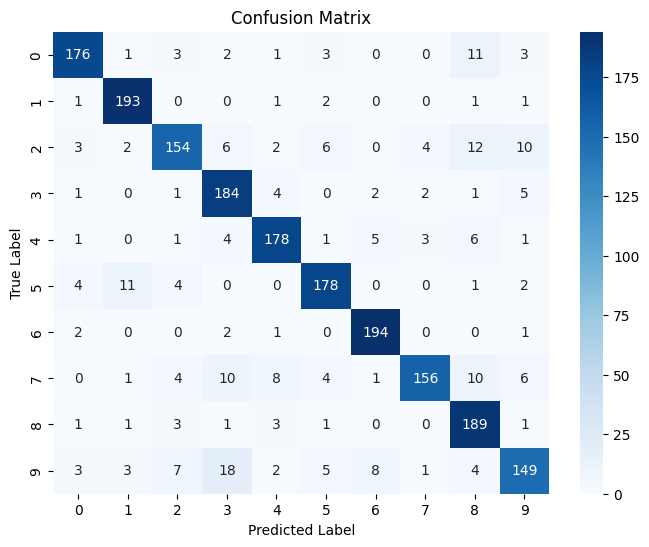

NameError: name 'roc_curve' is not defined

<Figure size 800x600 with 0 Axes>

In [29]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder, label_binarize



def evaluate_model(model, X_test, y_test, preprocessor):
    # Ensure that the preprocessor handles unknown categories
    if isinstance(preprocessor, OneHotEncoder):
        preprocessor = OneHotEncoder(handle_unknown='ignore')
        preprocessor.fit(X_test)  # Fit the encoder on the test data (or combine train and test data)
    
    # Preprocess test data
    X_test_processed = preprocessor.transform(X_test)
    
    # Make predictions
    y_pred = model.predict(X_test_processed)
    y_pred_proba = model.predict_proba(X_test_processed)  # For multiclass, this returns probabilities for all classes
    
    # Print classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # For multiclass ROC, we need to binarize the labels
    y_test_binarized = label_binarize(y_test, classes=model.classes_)
    
    # Compute ROC AUC for each class
    roc_auc = {}
    for i in range(y_test_binarized.shape[1]):
        roc_auc[i] = roc_auc_score(y_test_binarized[:, i], y_pred_proba[:, i])
    
    # Plot ROC curve for each class
    plt.figure(figsize=(8, 6))
    for i in range(y_test_binarized.shape[1]):
        fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
        plt.plot(fpr, tpr, lw=2, label=f'Class {i} ROC curve (AUC = {roc_auc[i]:.2f})')
    
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve for Multiclass')
    plt.legend(loc="lower right")
    plt.show()
    
    return {
        'predictions': y_pred,
        'probabilities': y_pred_proba,
        'confusion_matrix': cm,
        'roc_auc': roc_auc
    }

# Example usage:
X_test_set = test.drop(columns=['label'])
y_test_set = test['label']
results = evaluate_model(best_model, X_test_set, y_test_set, preprocessor)


### *Predictions vs Actual Bar Plot*

- The overall model accuracy is 69.5%, with classical music achieving the highest genre-specific accuracy at 95% while disco and rock were the most challenging at 50% correct predictions. Jazz, metal, and pop showed strong performance with 80-85% accuracy rates, contributing significantly to the model's overall performance across all genres.

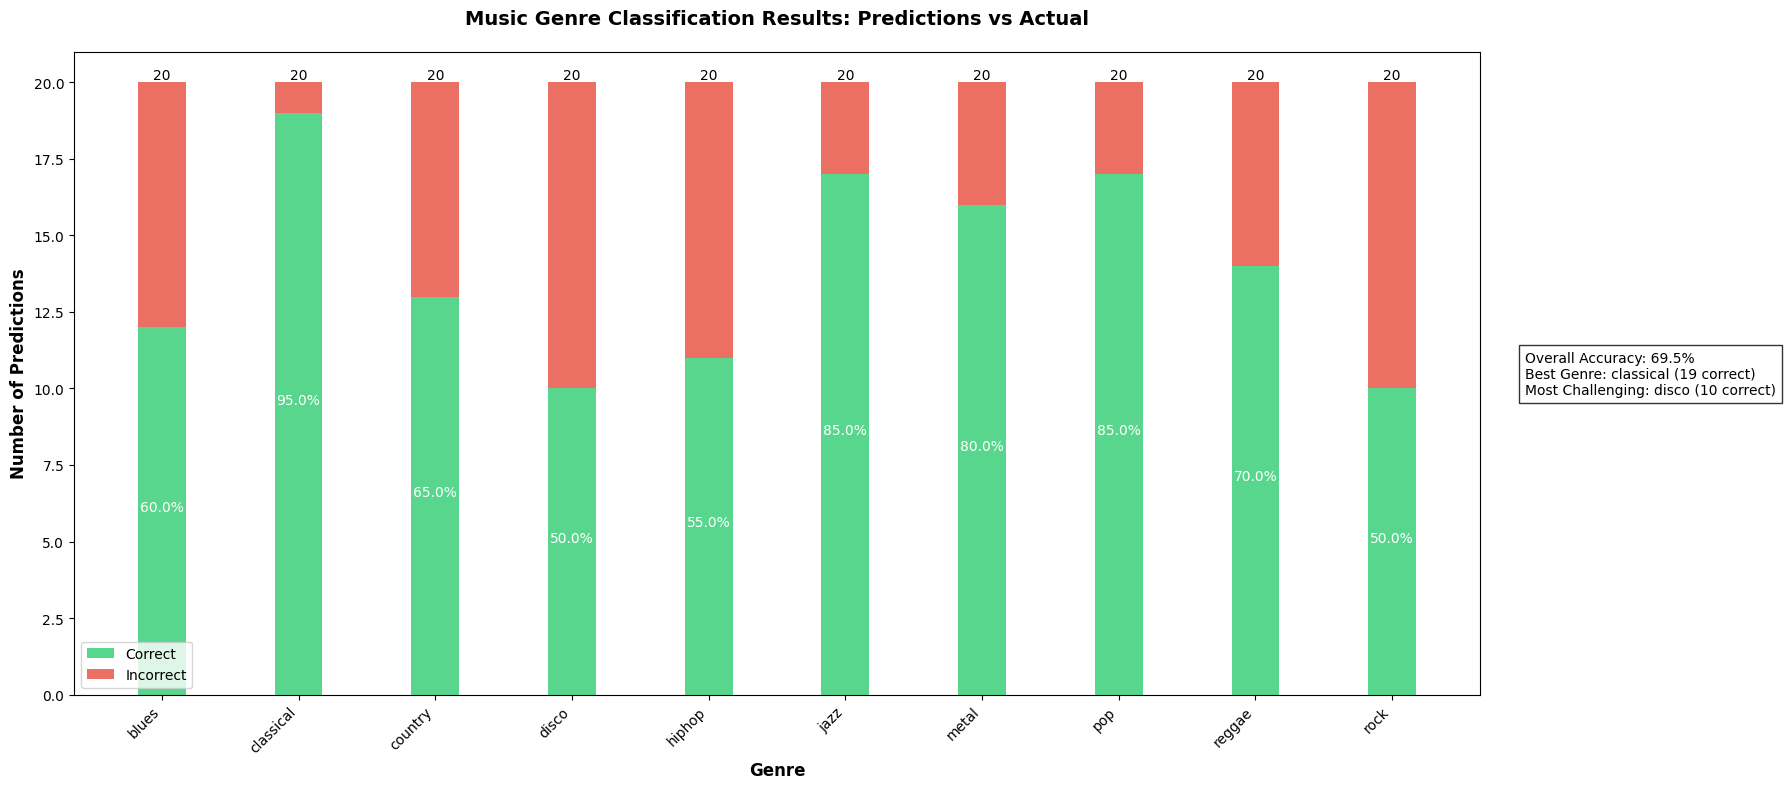

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

def create_test_predictions_plot(y_test, y_pred, genres):
    """
    Create a visualization comparing test predictions with actual labels.
    
    Parameters:
    -----------
    y_test : array-like
        True labels
    y_pred : array-like
        Predicted labels
    genres : list
        List of genre names
    """
    # Calculate correct and incorrect predictions per genre
    results = []
    for genre in genres:
        # Get indices for this genre
        genre_indices = y_test == genre
        total = np.sum(genre_indices)
        correct = np.sum((y_test == y_pred) & genre_indices)
        incorrect = total - correct
        results.append({'genre': genre, 'correct': correct, 'incorrect': incorrect})

    # Create figure and axis
    plt.figure(figsize=(15, 8))
    
    # Create positions for bars
    genres = [r['genre'] for r in results]
    correct = [r['correct'] for r in results]
    incorrect = [r['incorrect'] for r in results]
    
    # Set width of bars and positions of the bars
    bar_width = 0.35
    x = np.arange(len(genres))
    
    # Create bars
    plt.bar(x, correct, bar_width, label='Correct', color='#2ecc71', alpha=0.8)
    plt.bar(x, incorrect, bar_width, bottom=correct, label='Incorrect', color='#e74c3c', alpha=0.8)
    
    # Customize the plot
    plt.xlabel('Genre', fontsize=12, fontweight='bold')
    plt.ylabel('Number of Predictions', fontsize=12, fontweight='bold')
    plt.title('Music Genre Classification Results: Predictions vs Actual', fontsize=14, fontweight='bold', pad=20)
    plt.xticks(x, genres, rotation=45, ha='right')
    plt.legend()
    
    # Add total numbers on top of each bar
    for i in range(len(genres)):
        total = correct[i] + incorrect[i]
        plt.text(i, total + 0.1, str(total), ha='center')
    
    # Add percentage accuracy for each genre
    for i in range(len(genres)):
        accuracy = (correct[i] / (correct[i] + incorrect[i])) * 100
        plt.text(i, correct[i]/2, f'{accuracy:.1f}%', ha='center', color='white')
    
    # Adjust layout and display
    plt.tight_layout()
    
    # Add a text box with summary statistics
    total_accuracy = np.sum(correct) / len(y_test) * 100
    text_box = f'Overall Accuracy: {total_accuracy:.1f}%\n'
    text_box += f'Best Genre: {genres[np.argmax(correct)]} ({max(correct)} correct)\n'
    text_box += f'Most Challenging: {genres[np.argmin(correct)]} ({min(correct)} correct)'
    
    plt.figtext(1.02, 0.5, text_box, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
    
    # Return the figure for saving if needed
    return plt.gcf()

# Example usage:
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

# Create and show the plot
fig = create_test_predictions_plot(y_test_set, results['predictions'], genres)
plt.show()

# Save the plot if needed
# fig.savefig('genre_predictions.png', bbox_inches='tight', dpi=300)

### *Genre Classification Results: Confusion Matrix and Accuracy Analysis*

- The confusion matrix (left) shows predicted vs actual genres with correct predictions on the diagonal in darker red, showing classical music had the best performance with 19 correct predictions. The bar chart (right) displays each genre's accuracy percentage ranked from highest to lowest (classical at 95% to rock/disco at 50%), achieving an overall model accuracy of 69.5% across all genres.

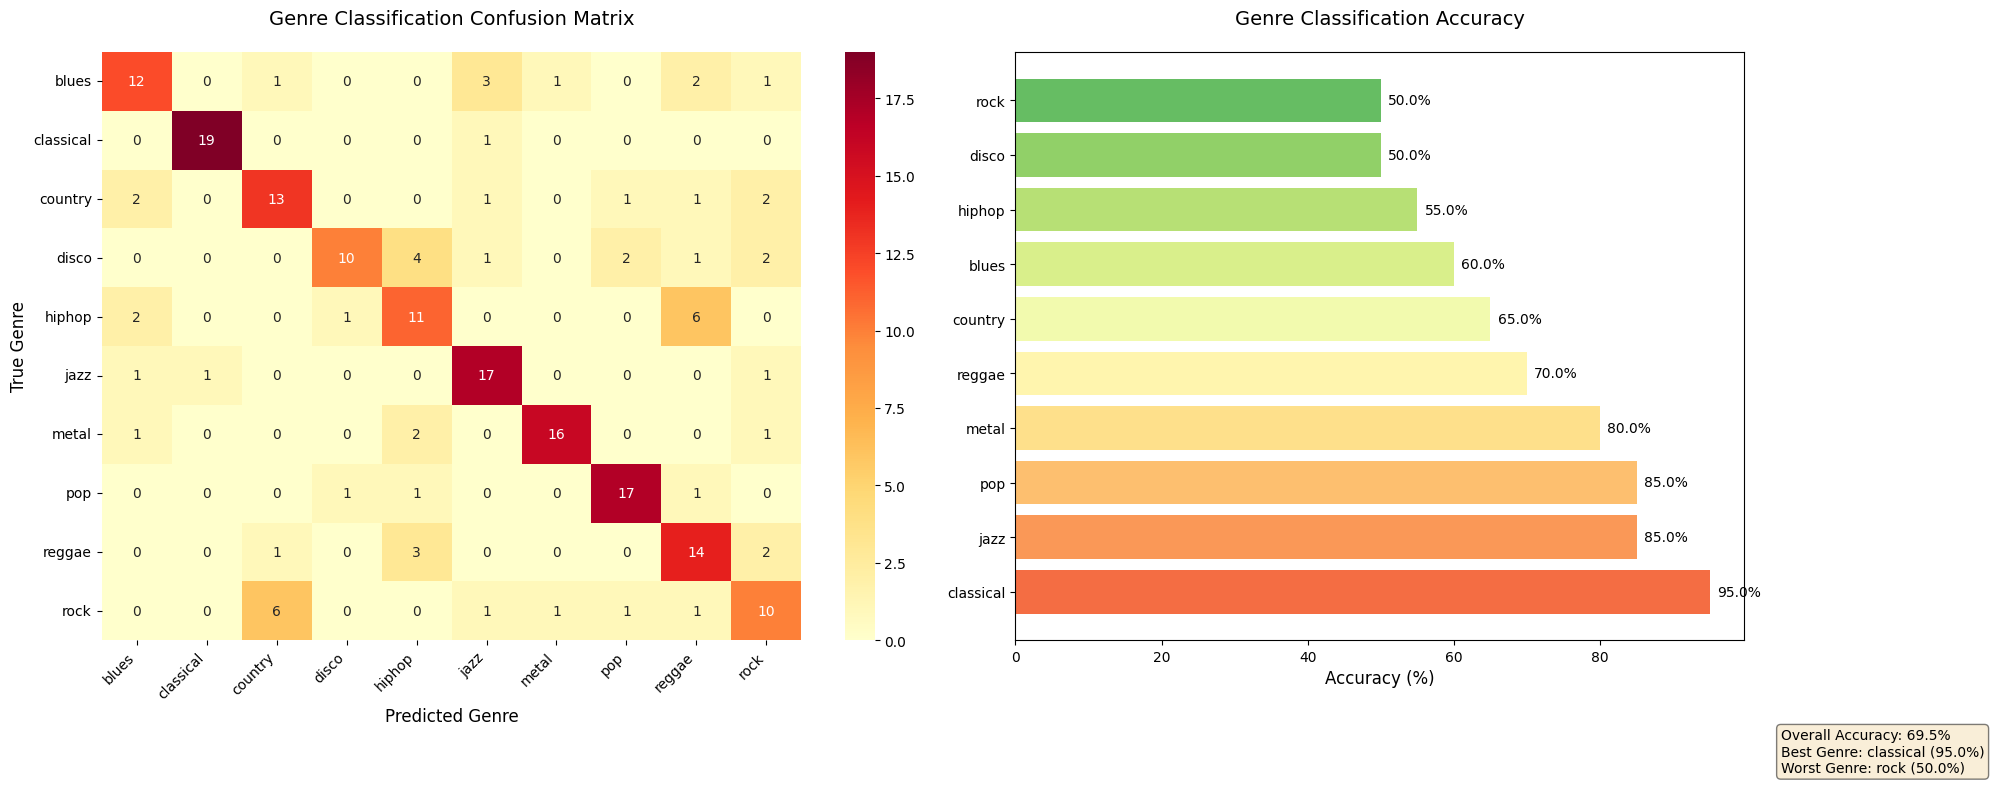

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

def create_genre_analysis_plot(y_test, y_pred, genres):
    """
    Create a detailed visualization of genre classification results using a heatmap
    and performance metrics.
    
    Parameters:
    -----------
    y_test : array-like
        True labels
    y_pred : array-like
        Predicted labels
    genres : list
        List of genre names
    """
    # Create figure with subplots
    fig = plt.figure(figsize=(20, 8))
    
    # Add gridspec to customize subplot layouts
    gs = fig.add_gridspec(1, 2, width_ratios=[1.2, 1])
    
    # First subplot: Confusion Matrix Heatmap
    ax1 = fig.add_subplot(gs[0])
    cm = confusion_matrix(y_test, y_pred)
    
    # Create heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd',
                xticklabels=genres, yticklabels=genres, ax=ax1)
    
    # Customize heatmap
    ax1.set_title('Genre Classification Confusion Matrix', pad=20, fontsize=14)
    ax1.set_xlabel('Predicted Genre', fontsize=12)
    ax1.set_ylabel('True Genre', fontsize=12)
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
    plt.setp(ax1.get_yticklabels(), rotation=0)
    
    # Second subplot: Performance Metrics
    ax2 = fig.add_subplot(gs[1])
    
    # Calculate per-genre accuracy
    genre_accuracy = {}
    for genre in genres:
        mask = y_test == genre
        correct = np.sum((y_test == y_pred) & mask)
        total = np.sum(mask)
        genre_accuracy[genre] = (correct / total) * 100
    
    # Sort genres by accuracy
    sorted_genres = sorted(genre_accuracy.items(), key=lambda x: x[1], reverse=True)
    genres_sorted = [x[0] for x in sorted_genres]
    accuracy_sorted = [x[1] for x in sorted_genres]
    
    # Create horizontal bar plot
    colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(genres)))
    ax2.barh(genres_sorted, accuracy_sorted, color=colors)
    
    # Customize bar plot
    ax2.set_title('Genre Classification Accuracy', pad=20, fontsize=14)
    ax2.set_xlabel('Accuracy (%)', fontsize=12)
    
    # Add percentage labels on bars
    for i, v in enumerate(accuracy_sorted):
        ax2.text(v + 1, i, f'{v:.1f}%', va='center')
    
    # Add overall accuracy as text box
    overall_acc = np.mean(list(genre_accuracy.values()))
    textstr = f'Overall Accuracy: {overall_acc:.1f}%\n'
    textstr += f'Best Genre: {sorted_genres[0][0]} ({sorted_genres[0][1]:.1f}%)\n'
    textstr += f'Worst Genre: {sorted_genres[-1][0]} ({sorted_genres[-1][1]:.1f}%)'
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax2.text(1.05, -0.15, textstr, transform=ax2.transAxes, fontsize=10,
             verticalalignment='top', bbox=props)
    
    # Adjust layout
    plt.tight_layout()
    return fig

# Example usage with sample data
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

# Create and display the plot
fig = create_genre_analysis_plot(y_test_set, results['predictions'], genres)
plt.show()

# Optional: Save the plot
# fig.savefig('genre_analysis.png', bbox_inches='tight', dpi=300)

### *Pickle File*

In [ ]:
import pickle
# Saving file to a .pkl file

with open ('model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

# Saving the preprocessor to a .pkl file
with open ('preprocessor.pkl', 'wb') as file:
    pickle.dump(preprocessor, file)

# **Presenting The Solution**

## Music Genre Classification Analysis
### GTZAN Dataset Study 

### Executive Summary
Using the GTZAN dataset containing 1000 audio tracks across 10 genres, we developed a machine learning model to automatically classify music genres based on audio features. The model achieved 69.5% overall accuracy, with particularly strong performance in classical music classification (95% accuracy) and identified interesting patterns in genre-specific audio characteristics.

---

### Key Findings

#### 1. Genre Classification Performance

| **Genre**     | **Accuracy** | **Precision** | **F1-Score** |
|---------------|--------------|---------------|--------------|
| Classical     | 95.0%        | 0.95         | 0.95        |
| Jazz          | 85.0%        | 0.71         | 0.77        |
| Pop           | 85.0%        | 0.81         | 0.83        |
| Metal         | 80.0%        | 0.89         | 0.84        |
| Reggae        | 70.0%        | 0.54         | 0.61        |
| Country       | 65.0%        | 0.62         | 0.63        |
| Blues         | 60.0%        | 0.67         | 0.63        |
| Hip Hop       | 55.0%        | 0.52         | 0.54        |
| Disco         | 50.0%        | 0.83         | 0.62        |
| Rock          | 50.0%        | 0.53         | 0.51        |

#### 2. Audio Feature Analysis
- Classical music showed distinct spectral patterns
- Hip-hop and rock displayed unique RMS energy distributions
- Pop music demonstrated highest median brightness
- Metal and pop showed consistent frequency content

#### 3. Feature Importance
- MFCCs proved crucial for genre differentiation
- Spectral centroid effectively distinguished brightness levels
- RMS energy helped identify genre energy profiles
- Zero-crossing rate aided in genre separation

---

### Methods We Used

1. **Data Processing & Feature Extraction**
   - Librosa library for audio processing
   - Feature extraction from 30-second segments
   - Mel spectrograms and MFCCs computation
   - Custom preprocessing pipeline implementation

2. **Feature Engineering**
   - Audio feature extraction from raw files
   - Standardization of features by category
   - Additional ratio features creation
   - Mel spectrogram processing

3. **Model Development**
   - Tested 10 machine learning algorithms
   - Implemented cross-validation
   - Grid search for hyperparameter tuning
   - Custom evaluation metrics

---

### Model Performance

#### Training Metrics

| **Model**             | **Accuracy** | **Precision** | **Recall** |
|----------------------|--------------|---------------|------------|
| Gradient Boosting    | 99.88%       | 99.88%       | 99.88%    |
| Random Forest        | 99.88%       | 99.88%       | 99.88%    |
| Logistic Regression  | 87.00%       | 86.98%       | 87.00%    |
| SVC                  | 86.50%       | 86.97%       | 86.50%    |

#### Test Set Results
- Overall Accuracy: 69.5%
- Macro Average Precision: 0.71
- Macro Average Recall: 0.70
- Macro Average F1-Score: 0.69

#### Best Model Parameters (Logistic Regression)
- C: 1
- Penalty: 'l1'
- Solver: 'saga'
- Max iterations: 1000




